In [2]:
from xai.policy import *
from xai.buffer import Buffer
from xai.bytes import GigaBytes
from numpy import uint8
from numpy.typing import NDArray
import matplotlib.pyplot as plt

import mnist
import torch
import random

In [ ]:
images = torch.from_numpy(mnist.train_images())
images = images.float()/255.0

labels = torch.from_numpy(mnist.train_labels())
labels_one_hot = torch.zeros((labels.shape[0],10)).float()
labels_one_hot[torch.arange(0,labels.shape[0]),labels.int()] = 1.0

images.shape, labels_one_hot.shape

In [ ]:
encoder = Policy.new((28,28),5)
decoder = Policy.new(5,(28,28))
autoencoder = encoder + decoder
autoencoder

In [ ]:
stats = autoencoder.adam().fit(
    X=images,
    Y=images,
    epochs=1000,
    batch_size=64,
    loss_criterion="MSELoss",
    verbose=True,
    info="Autoencoder test"
)
stats[5:].plot_loss()

In [ ]:
X = images[random.randint(0,len(images))]
feedforward = autoencoder(X)

Y = feedforward.numpy()

dY = feedforward.derivative(lambda t: t.sum(), order=1).cpu().numpy()

fig = plt.figure(figsize=(10,7)) 
fig.add_subplot(1,3,1)
plt.imshow(X, cmap="gray") 
fig.add_subplot(1,3,2)
plt.imshow(Y, cmap="gray") 
fig.add_subplot(1,3,3)
plt.imshow(dY, cmap="gray")

In [3]:
scale = 10
images = mnist.train_images()

def upscale_image() -> Iterator[Tensor]:
    image: NDArray[uint8]
    for image in images:
        yield torch.from_numpy(image.repeat(scale,0).repeat(scale,1)).float() / 255.0

big_images = Buffer(
    entries=upscale_image(), 
    eviction_policy="Reject", 
    use_ram=False, 
    max_memory=GigaBytes(0.5), 
    verbose=True
    )

labels = torch.from_numpy(mnist.train_labels())
labels_one_hot = torch.zeros((labels.shape[0],10)).float()
labels_one_hot[torch.arange(0,labels.shape[0]),labels.int()] = 1.0

big_images, big_images[0].shape

Disk used: 0.50/0.50GB: : 1592it [00:03, 515.31it/s]


(Buffer(use_ram=False, entries=1592, size=499.90MB, capacity=99.98%),
 torch.Size([280, 280]))

In [4]:
hidden_dims = [2**8,2**6,2**5]
big_encoder = Policy.new((28*scale,28*scale),5, hidden_layers=hidden_dims)
big_decoder = Policy.new(5,(28*scale,28*scale), hidden_layers=hidden_dims[::-1])
big_autoencoder = big_encoder + big_decoder
big_autoencoder

/home/eivind/master-project/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Sequential(
  (0): Linear(in_features=78400, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=5, bias=True)
  (7): Linear(in_features=5, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=78400, bias=True)
)

In [5]:
stats = big_autoencoder.adam().fit(
    X=big_images,
    Y=big_images,
    epochs=1000,
    batch_size=64,
    loss_criterion="MSELoss",
    verbose=True,
    info="Big autoencoder train test"
)
stats[5:].plot_loss()

Loss: 0.047963:  11%|█         | 111/1000 [00:50<06:42,  2.21it/s]


KeyboardInterrupt: 

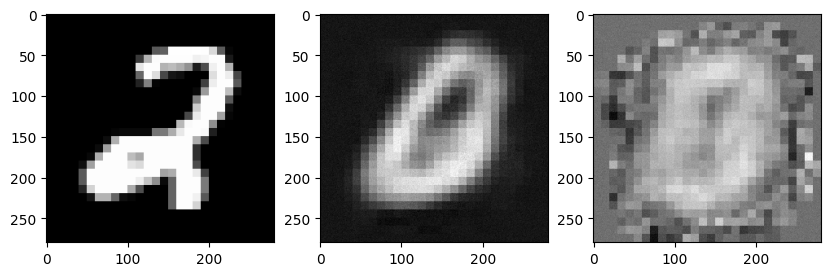

In [6]:
X = big_images[random.randint(0,len(big_images))]
feedforward = big_autoencoder.predict(X)

Y = feedforward.numpy()

dY = feedforward.derivative(lambda t: t.sum(), order=1).cpu().numpy()

fig = plt.figure(figsize=(10,7)) 
fig.add_subplot(1,3,1)
plt.imshow(X, cmap="gray") 
fig.add_subplot(1,3,2)
plt.imshow(Y, cmap="gray") 
fig.add_subplot(1,3,3)
plt.imshow(dY, cmap="gray")